In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.optimize as opt
import time
from datetime import datetime
from threading import Timer
import scipy.signal as sig
from scipy.interpolate import UnivariateSpline
from qkit.analysis.circle_fit.circle_fit_2019 import circuit

QKIT configuration initialized -> available as qkit.cfg[...]


# Qubit Frequency Domain Measurements
The first step in characterizing a Qubit, is finding its readout resonators. Then, using flux coils (so, a current source) can be used to tune the qubit, which affects the readout resonators frequency (see Dispersive Shift).

To gauge the qubits energy levels, two-tone spectroscopy can be used.

This notebook implements the necessary step to get a good idea in frequency domain about what your qubit is doing.

**NOTE:** It is recommended to use a new copy of this template for each qubit. This will give you the newest features, and loss of notebooks isn't as severe.

Cells requiring your input are preceded by **bold text indicating user information.**

## QKit Configuration
First, Qkit and the device is initialized. **Input the run_id and your name below.**

In [2]:
# import and start qkit

import qkit
qkit.cfg['load_visa']=True
qkit.cfg['run_id']='EDEL_18'
qkit.cfg['user']=r'Your_Name_Here'
qkit.start()

from qkit.storage.store import Data
import qkit.analysis.qfit as qfit
import qkit.measure.samples_class as sc

2023-06-06 13:45:45 [WARNING ]: Your qkit version is older than 3 weeks. Please consider the 'git pull' command. We are usually trying to get better. (S20_check_for_updates.py:21)


Starting QKIT framework ... -> qkit.core.startup
Loading module ... S10_logging.py
Loading module ... S14_setup_directories.py
Loading module ... S16_available_modules.py
Loading module ... S20_check_for_updates.py
Loading module ... S25_info_service.py
Loading module ... S30_qkit_start.py
Loading module ... S65_load_RI_service.py
Loading module ... S70_load_visa.py
Loading module ... S80_load_file_service.py
Loading module ... S85_init_measurement.py


Loading module ... S98_started.py
Loading module ... S99_init_user.py


## Load Instruments
Here, the instruments required for the experiments are loaded. You may skip some, if your particular measurement doesn't need them.

**Enter the device names**

### Microwave Switch
The microwave switch allows you to switch between samples in the fridge. Which microwave switch you need, depends on the fridge you use.

**Enter the microwave switch name**

In [3]:
switch = qkit.instruments.create_from_config("switch-edel")

Connecting to switch server...
Initialized the file info database (qkit.fid) in 1.078 seconds.


**Enter the output of the switch connected to your sample**

In [4]:
#switch.set_pulse_length(0.08)

In [5]:
#switch.get_pulse_length()

In [6]:
#switch.reset(2)

In [7]:
#switch.switch_to(2,2)

In [ ]:
switch.ensure_switch_at(2, 3)

In [8]:
#switch.enable(2,3)
#switch.disable(2,5)

In [9]:
switch.get_position(2)

'[2]'

### Microwave Source
**Enter the name of the microwave source you want to use, and attenuation, if present.**

In [ ]:
# create mw source
mw_src = qkit.instruments.create_from_config("mw-134") # Alternatives: mw-21 or mw-94
mw_src.set_power_offset(0) # Attenuation in dB. If you attenuate by -10dB, then set this to -10

In [12]:
# turn on/off mw source
mw_src.set_status(False)
mw_src.get_status()

False

### Current Source for Flux Tuning
We use a current source to apply a local magnetic field to your qubit. Load a current source.
**Change the device name as needed.**

In [68]:
# create DC source
IVD = qkit.instruments.create_from_config('cs-129', reset=True) # or cs-130

In [69]:
# settings

IVD.set_measurement_mode(0)
IVD.set_bias_mode(0)
#IVD.set_bias_range(2e-1)
#IVD.set_sense_mode(1)
#IVD.set_sense_limit(0.5)
#IVD.get_all()

IVD.set_current(0)
IVD.set_status(0)
IVD.get_status()

False

#### QDevil Setup

In [13]:
IVD = qkit.instruments.create_from_config('qdevil')

In [41]:
channel = 1

voltage = -1e-3

In [42]:
IVD.set_DC_voltage(channel, voltage)

In [70]:
#IVD.reset()

### Vector Network Analyzer
The vector network analyzer tests the frequency response of the sample.

We often use directional couplers to add a second microwave tone. If it is present, it usually adds -20dB of attenuation. **Document the attenuation**.

In [14]:
# create VNA
vna = qkit.instruments.create_from_config("vna-136") # or vna-132, vna-131
mw_src.set_power_offset(0) # in dB. If you attenuate by -20dB, write -20
from qkit.measure.spectroscopy.spectroscopy import spectrum
s = spectrum(vna)

## TIP Client (thermometer)
We apply current to samples in the fridge. This is fine, if they stay superconducting. If the critical current is exceeded, the fridge may heat up rapidly, which may negatively affect samples in the same fridge. This needs to be prevented. Hence, we monitor the temperature.

In [16]:
tip = qkit.instruments.create_from_config("tip-edel") # or tip-perl
tip.define_default_thermometer('mxc')

def get_T():
    try:
        return float(tip.get_param(device='mxc', param='temperature'))
    except:
        return np.nan
get_T()

Connecting to TIP server...


0.010681998434482764

## Helper Functions

In [17]:
# function estimates the duration of a measurement

def estimate_measurement_time(dim=2):
    if dim==1:
        t_meas = vna.get_sweeptime_averages()
    elif dim==2:
        t_meas = vna.get_sweeptime_averages()*s.x_vec.size
    elif dim==3:
        t_meas = vna.get_sweeptime_averages()*s.x_vec.size*s.y_vec.size
    timestamp = time.time()+t_meas
    
    if t_meas/60 < 180:
        print('Masurement duration: ' + str(round(t_meas/60,1)) + ' min, ends at ', datetime.fromtimestamp(timestamp))
    elif t_meas/60 >= 180:
        print('Masurement duration: ' + str(round(t_meas/3600,2)) + ' h, ends at ', datetime.fromtimestamp(timestamp))

    return 

In [18]:
# function returnes the wiki entry

def get_wiki_entry():
    print('| ', sep='', end='')
    print(s._data_file._uuid, sep='', end='')
    print(' |  | ', sep='', end='')
    if s._scan_dim > 1:
        print('{:f}{:s} to {:f}{:s} in {:f}{:s}'.format(s.x_vec[0],
                                                        s.x_unit,
                                                        s.x_vec[-1],
                                                        s.x_unit,
                                                        (s.x_vec[-1]-s.x_vec[0])/(s.x_vec.size-1),
                                                        s.x_unit),
              sep='', end='')
    else:
        print('---', sep='', end='')
    print(' | ', sep='', end='')
    if s._scan_dim > 2:
        print('{:f}{:s} to {:f}{:s} in {:f}{:s}'.format(s.y_vec[0],
                                                        s.y_unit,
                                                        s.y_vec[-1],
                                                        s.y_unit,
                                                        (s.y_vec[-1]-s.y_vec[0])/(s.y_vec.size-1),
                                                        s.y_unit),
              sep='', end='')
    else:
        print('---', sep='', end='')
    print(' | ', sep='', end='')
    print(vna.get_bandwidth(), ' | ', vna.get_averages(), ' | ', vna.get_power(), ' | ', vna.get_span()/1e6, ' | ', vna.get_nop(), ' | ', sep='', end='')
    print(IVD.get_current(), ' | ', mw_src.get_power(), ' | ', mw_src.get_frequency()/1e9, sep='', end='')
    print(' |  |', sep='', end='')

In [19]:
# functions used to implement a killswitch of the DC-current source depending on a cryo temperature threshold

temp_threshold = 15e-3 # mK
enable_heatstop = False

# Trigger function: True if the measured temperature exceeds the trigger temperature, False otherwise
def temperature_killswitch(trigger = temp_threshold):
    if enable_heatstop:
        temp = get_T()
        if temp > trigger:
            return True
        else:
            return False
    else:
        return False
    
# Stop the DC current source
def stop_current():
    if enable_heatstop:
        stop_point = IVD.get_current() # beware! get_current turns on current again
        IVD.set_current(0)
        IVD.set_status(False)
        sys.exit("Heat Stop at "+ str(stop_point/1e-3) + " mA; Current status: " +str(IVD.get_status()))

In [20]:
# Function to calculate measurement points, good eg. for ramping the current up and down
# INPUT: array with checkpoints that need to be reached in the measurement (eg. [start_value, stop_value]); step size
# OUTPUT: array with all corresponding measurement points
# WARNING: If used for sweeping a parameter up and back down and the step size does not correspond in the interval (eg. INPUT ([1, 8], 3)),
# the points on ramp up and ramp down will not correspond
def measurement_points(checkpoints, step):
    points = np.array([])
    step = abs(step)
    for i in range(1, len(checkpoints)):
        if checkpoints[i] > checkpoints[i-1]:
            points = np.append(points, np.arange(checkpoints[i-1], checkpoints[i], step))
        else:
            points = np.append(points, np.arange(checkpoints[i-1], checkpoints[i], -step))
    points = np.append(points, checkpoints[-1])
    return points

In [21]:
# Resonator calibration: search for optimal working point of resonator (VNA)

def resonator_calibration(cal_nop, cal_span, cal_bw, cal_avg, mode):
    
    # Initialization
    mw_src.set_status(False) # turn off mw source during search
    vna.set_nop(cal_nop)
    vna.set_centerfreq(res_freq)
    vna.set_span(cal_span) # search the span aroud the resonator position
    vna.set_bandwidth(cal_bw) # large IF bandwith, many averages
    vna.set_averages(cal_avg)
    vna.set_Average(True)

    # Resonator measurement with MW source OFF
    vna.pre_measurement()
    vna.start_measurement()
    while not vna.ready(): # wait till end of measurement
        if temperature_killswitch():
            stop_current()
            return 
        else:
            time.sleep(1e-1)
            
    # Find reesonance frequency
    
    # use phase derivative
        s.freq = vna.get_freqpoints()
        s.amp, s.pha = vna.get_tracedata() # dataset with the amp and phase data to find the resonator
        try:
            # use phase 
            if mode == "pha" or "phase":
                # Savitzky-Golay-Filter: digital smoothing filter, increases the precision without distorting the signal tendency
                # Convolution of low-degree polynomial over the data and fit
                pha_savgol = - sig.savgol_filter(s.pha, window_length=9, polyorder=3, deriv=1)
                peaks = sig.find_peaks(pha_savgol, prominence=4e-2)
                peak = sig.find_peaks(pha_savgol, prominence=np.max(peaks[1]['prominences']))
            
            # use amplitude
            elif mode == "amp" or "amplitude":
                peaks = sig.find_peaks(-s.amp, prominence= 5e-4)
                peak = sig.find_peaks(-s.amp, prominence=np.max(peaks[1]['prominences']))
            
            return s.freq[peak[0][0]]
        except:
            return 0

In [22]:
# Set bias flux/current

def set_dc_bias(dc_bias, mode = "set", dc_time = 0.1):
    max_current = 8.0e-3 # max. dc current allowed
    dc_step = 10e-6
    
    # if None then turn off source
    if dc_bias == None:
        IVD.set_status(False)
        return "DC source turned off."
    
    # check, if current value does not exceed maximum value
    if abs(dc_bias) > max_current:
        return "Please select a DC current bias value lower than " + str(max_current) + " A!"
        
    # set current source to zero and turn on source
    IVD.set_current(0)
    IVD.set_measurement_mode(0)
    IVD.set_bias_mode(0)
    IVD.set_status(True)
    
    # set or ramp current
    if mode == "set":
        IVD.set_current(dc_bias)
    elif mode == "ramp":
        IVD.ramp_current(dc_bias, dc_step, dc_time)
    
    return "DC source set to " + str(round(IVD.get_current()*1e3,3)) + " mA"

In [23]:
def res_path(res):
    path_name = ''
    
    if res == 1:
        path_name = r'\\Res_1'
    elif res == 2:
        path_name = r'\\Res_2'
    elif res == 3:
        path_name = r'\\Res_3'
    elif res == 4:
        path_name = r'\\Res_4'
        
    return path_name

# Measurements
Now, we can start the actual measurements. Usually, only one qubit is measured at a time.

**Add the sample information below.**

## Sample Definition

In [27]:
sample = sc.Sample()
sample.name = 'SAMPLE_NAME'
sample.temperature = '~10mK'
sample.setup = 'directional coupler: -20 dBm, damping at mw source -20 dBm'
print(sample.get_all())
s._measurement_object.sample = sample

dir_sample =r'Alex\\sample_C28'

comment:   
name:   GeQCoS-4Q-v4-3-C28
setup:   directional coupler: -20 dBm, damping at mw source -20 dBm
temperature:   ~10mK



#### C28 Res 1 (7.84 GHz)

In [26]:
# resonator 1 / qubit 1

exp_name = "GeQCoS4Qv4_3_C28_r1"
res = 1
res_freq = 7.842e9

vna.set_centerfreq(res_freq)
s.exp_name= exp_name

def initial_calibration_R1(delay = 62.102e-9):
    vna.set_measurement_parameter('S21')
    vna.set_power(-40)
    vna.set_bandwidth(100)
    vna.set_span(20e6)
    vna.set_nop(101)
    vna.set_centerfreq(res_freq)
    vna.do_set_edel_status(True) # port extension
    vna.do_set_edel(delay, 1)
    vna.set_Average(False)
    return

initial_calibration_R1()

Initialized the file info database (qkit.fid) in 1.258 seconds.


In [27]:
s.exp_name = exp_name

In [28]:
vna.set_centerfreq(res_freq)

True

### Sample: v4_3_C48

In [24]:
sample = sc.Sample()
sample.name = 'GeQCoS-4Q-v4-3-C48'
sample.temperature = '~10mK'
sample.setup = 'directional coupler: -20 dBm, damping at mw source -20 dBm'
print(sample.get_all())
s._measurement_object.sample = sample

dir_sample =r'Alex\\sample_C48'

comment:   
name:   GeQCoS-4Q-v4-3-C48
setup:   directional coupler: -20 dBm, damping at mw source -20 dBm
temperature:   ~10mK



#### C48 Res 1 (7.81 GHz)

In [41]:
# resonator 1 / qubit 1

exp_name = "GeQCoS4Qv4_3_C48_r1"
res = 1
res_freq = 7.810e9

vna.set_centerfreq(res_freq)
s.exp_name= exp_name

def initial_calibration_R1(delay = 61.286e-9):
    vna.set_measurement_parameter('S21')
    vna.set_power(-40)
    vna.set_bandwidth(100)
    vna.set_span(20e6)
    vna.set_nop(201)
    vna.set_centerfreq(res_freq)
    vna.do_set_edel_status(True) # port extension
    vna.do_set_edel(delay, 1)
    vna.set_Average(False)
    return

initial_calibration_R1()

## Resonator Measurement

### 1D Trace

In [90]:
# set the flux bias
set_dc_bias(-600e-6)

'DC source set to -0.6 mA'

In [91]:
IVD.get_status()

True

In [330]:
# Measurement parameters

# VNA 
vna_power = -35 # dBm
vna_nop  = 201 
vna_span = 10e6 # Hz
vna_avg = 3
vna_bw = 50 # Hz

In [331]:
vna.set_power(vna_power)

True

In [332]:
vna.set_nop(vna_nop)
vna.set_span(vna_span)

True

In [333]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [334]:
vna.set_bandwidth(vna_bw)

True

In [97]:
s.set_resonator_fit(fit_resonator=True, fit_function='circle_fit_reflection')

In [98]:
qkit.cfg['user']= dir_sample + r'\\Resonator_Trace' + res_path(res)
s.dirname = exp_name + "_1D_scan"

In [99]:
s.measure_1D()

HTML(value="<table style='width:100%'><tr><td> (0/3) </td><td>&#9992; 2023-04-26 (Wed) 13:47:53    </td><td>&#…

IntProgress(value=0, description='GeQCoS4Qv4_3_C28_r1_1D_scan', layout=Layout(width='95%'), max=3)

2023-04-26 13:47:53 [WARNING ]: Data does not cover a full circle (only 2.8 rad). Increase the frequency span around the resonance? (circuit.py:427)
2023-04-26 13:47:53 [WARNING ]: Data does not cover a full circle (only 2.8 rad). Increase the frequency span around the resonance? (circuit.py:427)
2023-04-26 13:47:53 [WARNING ]: Data does not cover a full circle (only 2.8 rad). Increase the frequency span around the resonance? (circuit.py:427)


0 True
C:\data\EDEL_18\Alex\\sample_C28\\Resonator_Trace\RTQ0RH_GeQCoS4Qv4_3_C28_r1_1D_scan_GeQCoS4Qv4_3_C28_r1\RTQ0RH_GeQCoS4Qv4_3_C28_r1_1D_scan_GeQCoS4Qv4_3_C28_r1.h5


C:\qkit\qkit\analysis\circle_fit\circle_fit_2019\circuit.py:309: RuntimeWarning: invalid value encountered in sqrt
  R_err = self.r0 * np.sqrt(b**2 - np.sin(self.phi)**2)


Plots saved in C:\data\EDEL_18\Alex\sample_C28\Resonator_Trace\RTQ0RH_GeQCoS4Qv4_3_C28_r1_1D_scan_GeQCoS4Qv4_3_C28_r1\images


### 2D Power scan

In [41]:
# set the flux bias
dc_bias =  850e-6
set_dc_bias(dc_bias)

'DC source set to 0.85 mA'

In [42]:
IVD.get_status()

True

In [43]:
# Measurement parameters

# Power sweep
power_start = -30 # dBm
power_stop = -10 # dBm
power_step = 10 # dBm

power_points = measurement_points([power_start, power_stop], power_step)

# VNA 
vna_nop  = 401 
vna_span = 20e6 # Hz
vna_avg = 5
vna_bw = 50 # Hz

In [44]:
vna.set_span(vna_span)
vna.set_nop(vna_nop)

True

In [45]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [46]:
vna.set_bandwidth(vna_bw)

True

In [47]:
s.set_resonator_fit(fit_resonator=False, fit_function='circle_fit_reflection')

In [48]:
s.set_x_parameters(x_vec=power_points,
                   x_coordname='VNA_power', 
                   x_set_obj=vna.set_power, 
                   x_unit='dBm')

estimate_measurement_time(2)

Masurement duration: 1.9 min, ends at  2023-05-31 10:57:59.963427


In [49]:
vna.set_power(power_start)

True

In [50]:
s.comment = """Directional coupler : -20dBm VNA, MW source: """ + str(vna_att) +  """ dBm external"""
#s.comment = """no directional coupler"""

In [51]:
#name_extension = "_at_" + str(round(dc_bias*1e6,0)) +"µA_bias_" + "(half_Phi0)"
name_extension = "_at_" + "half_Phi0"
qkit.cfg['user']= dir_sample + r'\\Resonator_Power' + res_path(res)
s.dirname = exp_name + "_powerscan_" + str(int(power_start)) + "_to_" + str(int(power_stop)) + "_dBm" + name_extension

In [52]:
s.measure_2D()
vna.set_power(power_start)

HTML(value="<table style='width:100%'><tr><td> (0/3) </td><td>&#9992; 2023-05-31 (Wed) 10:58:10    </td><td>&#…

IntProgress(value=0, description='2D VNA sweep GeQCoS4Qv4_3_C48_r3_powerscan_-30_to_-10_dBm_at_half_Phi0', lay…

C:\data\EDEL_18\Alex\\sample_C48\\Resonator_Power\\Res_3\RVIM5R_2D_GeQCoS4Qv4_3_C48_r3_powerscan_-30_to_-10_dBm_at_half_Phi0_GeQCoS4Qv4_3_C48_r3\RVIM5R_2D_GeQCoS4Qv4_3_C48_r3_powerscan_-30_to_-10_dBm_at_half_Phi0_GeQCoS4Qv4_3_C48_r3.h5


True

Plots saved in C:\data\EDEL_18\Alex\sample_C48\Resonator_Power\Res_3\RVIM5R_2D_GeQCoS4Qv4_3_C48_r3_powerscan_-30_to_-10_dBm_at_half_Phi0_GeQCoS4Qv4_3_C48_r3\images


### 2D Current scan

In [1]:
# set the flux bias
dc_bias =  0
set_dc_bias(dc_bias)

NameError: name 'set_dc_bias' is not defined

In [2]:
IVD.get_status()

NameError: name 'IVD' is not defined

In [70]:
dc_start = -2.475e-3 # A
dc_stop = 2.475e-3 # A
dc_step = 0.030e-3 # A

current_points = measurement_points([dc_start, dc_stop], dc_step)

dc_time = 0.25

# VNA 
vna_nop  = 301 
vna_span = 80e6 # Hz
vna_avg = 5
vna_bw = 100 # Hz
vna_power = -40#-42.5 # dB

In [57]:
dc_start = -1.5e-3 # A
dc_stop = 1.5e-3 # A
dc_step = 20.0e-6 # A

current_points = measurement_points([100*dc_start, 100*dc_stop], 100*dc_step)

dc_time = 0.25

# VNA 
vna_nop  = 301 
vna_span = 80e6 # Hz
vna_avg = 5
vna_bw = 100 # Hz
vna_power = -40#-42.5 # dB

In [71]:
vna.set_power(vna_power)

True

In [72]:
vna.set_span(vna_span)
vna.set_nop(vna_nop)

True

In [73]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [74]:
vna.set_bandwidth(vna_bw)

True

In [75]:
def x_function(i):
    #IVD.set_current(i)
    """
    set_current(self, val, channel=1):
    
    Sets current value of channel <channel> to <val>.

    Parameters
    ----------
    val: float
        Bias current value.
    channel: int
        Number of channel of interest. Must be 1 for SMUs with only one channel and 1 or 2 for SMUs with two channels. Default is 1.
    """
    
    IVD.ramp_current(i, dc_step, dc_time)
    #IVD.set_DC_voltage(1, i)
    """
    ramp_current(self, stop, step, step_time=0.1, channel=1):
    
    Ramps current of channel <channel> from recent value to stop value <stop> with step size <step> and step time <step_time> according to bias_mode.

    Parameters
    ----------
    stop: float
        Stop current value
    step: float
        Step current size.
    step_time: float
        Sleep time between current staircase ramp.
    channel: int
        Number of channel of interest. Must be 1 for SMUs with only one channel and 1 or 2 for SMUs with two channels. Default is 1. (default)
    """
    
s.set_x_parameters(x_vec=current_points,
                   x_coordname='current_bias', 
                   x_set_obj=x_function, 
                   x_unit='Amp')

estimate_measurement_time(2)

Masurement duration: 40.0 min, ends at  2023-06-06 16:15:51.914758


In [76]:
s.comment = """Directional coupler : -20dBm VNA, MW source: """ + str(vna_att) +  """ dBm external"""
#s.comment = """no directional coupler"""

In [77]:
qkit.cfg['user']= dir_sample + r'\\Resonator_Current' + res_path(res)
s.dirname = exp_name + "_current_sweep_" + str(round(dc_start/1e-3,1)) + "_to_" + str(round(dc_stop/1e-3,1)) + "_mA"

In [78]:
s.set_resonator_fit(fit_resonator=False, fit_function='circle_fit_reflection')

In [79]:
IVD.set_current(0)
IVD.set_status(True)
IVD.set_measurement_mode(0)
IVD.set_bias_mode(0)

In [210]:
#IVD.ramp_current(dc_start, dc_step, dc_time)
IVD.set_current(dc_start)

In [80]:
s.measure_2D()
#IVD.set_DC_voltage(1, 0)
IVD.set_current(0)
IVD.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/166) </td><td>&#9992; 2023-06-06 (Tue) 16:16:02    </td><td>…

IntProgress(value=0, description='2D VNA sweep GeQCoS4Qv4_3_C48_r3_current_sweep_-2.5_to_2.5_mA', layout=Layou…

C:\data\EDEL_18\Alex\\sample_C48\\Resonator_Current\\Res_3\RVU343_2D_GeQCoS4Qv4_3_C48_r3_current_sweep_-2.5_to_2.5_mA_GeQCoS4Qv4_3_C48_r3\RVU343_2D_GeQCoS4Qv4_3_C48_r3_current_sweep_-2.5_to_2.5_mA_GeQCoS4Qv4_3_C48_r3.h5
Plots saved in C:\data\EDEL_18\Alex\sample_C48\Resonator_Current\Res_3\RVU343_2D_GeQCoS4Qv4_3_C48_r3_current_sweep_-2.5_to_2.5_mA_GeQCoS4Qv4_3_C48_r3\images


## Two Tone Measurements

### 2D 2-tone

In [56]:
# set the flux bias
dc_bias = 850e-6
set_dc_bias(dc_bias)

'DC source set to 0.85 mA'

In [57]:
IVD.get_status()

True

In [58]:
res_freq = vna.get_centerfreq()
vna.get_centerfreq()

7595226437.39

In [112]:
# Measurement parameter

# mw drive
mw_start = 7.0e9 # Hz
mw_stop = 8.2e9 # Hz
mw_step = 10e6 # Hz
mw_power = -25 # -20 dBm is max without eternal damping

mw_points = measurement_points([mw_start, mw_stop], mw_step)

# VNA
vna_nop  = 401 
vna_span = 20e6 # Hz
vna_avg = 50
vna_bw = 50 # Hz
vna_power = -40 # dB

In [113]:
mw_src.set_power_offset(mw_att)

In [114]:
vna.set_power(vna_power)

True

In [115]:
vna.set_span(vna_span)
vna.set_nop(vna_nop)

True

In [116]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [117]:
vna.set_bandwidth(vna_bw)

True

In [118]:
# Measurement with one point: One point (centerfreq) in amp. dip or phase edge

"""
res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(1)
"""

'\nres_freq = vna.get_centerfreq()\nvna.get_centerfreq()\nvna.set_nop(1)\n'

In [119]:
# Measurement with two points: One point (centerfreq) in amp. dip or phase edge and second point about 500 KHz left or right 

"""
vna.set_startfreq(res_freq)
vna.set_stopfreq(res_freq+300e3)
vna.set_nop(2)
"""

'\nvna.set_startfreq(res_freq)\nvna.set_stopfreq(res_freq+300e3)\nvna.set_nop(2)\n'

In [120]:
# Measurement with three points: One point (centerfreq) in amp. dip or phase edge and one point left and right each (baseline)

res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(3)

True

In [121]:
s.set_x_parameters(x_vec=mw_points,
                   x_coordname='mw_frequency', 
                   x_set_obj=mw_src.set_frequency, 
                   x_unit='Hz')

estimate_measurement_time(2)

Masurement duration: 5.8 min, ends at  2023-05-31 11:54:33.323002


In [122]:
s.comment = """Directional coupler : -20dBm VNA, MW source: """ + str(vna_att) +  """ dBm external"""
#s.comment = """no directional coupler"""

In [123]:
#name_extension = "_at_" + str(round(dc_bias*1e6,0)) +"µA_bias_" + "(full_Phi0)"
name_extension = "_at_half_Phi0"
qkit.cfg['user']= dir_sample + r'\\TwoTone_Trace' + res_path(res)
s.dirname = exp_name + "_2tone_at_" +  str(round(mw_power,1)) + "_dBm_" + str(round(mw_start/1e9,1)) + "_to_" + str(round(mw_stop/1e9,1)) + "_GHz" + str(round(mw_step/1e6,1)) + "_MHz_step" + name_extension
s.dirname = 'shortened'

In [124]:
mw_src.set_power(mw_power)
mw_src.set_status(True)

s.measure_2D()

mw_src.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/121) </td><td>&#9992; 2023-05-31 (Wed) 11:54:34    </td><td>…

IntProgress(value=0, description='2D VNA sweep shortened', layout=Layout(width='95%'), max=121)

C:\data\EDEL_18\Alex\\sample_C48\\TwoTone_Trace\\Res_3\RVIOL9_2D_shortened_GeQCoS4Qv4_3_C48_r3\RVIOL9_2D_shortened_GeQCoS4Qv4_3_C48_r3.h5


True

Plots saved in C:\data\EDEL_18\Alex\sample_C48\TwoTone_Trace\Res_3\RVIOL9_2D_shortened_GeQCoS4Qv4_3_C48_r3\images


### 3D 2-tone power sweep

In [161]:
# set the flux bias
dc_bias = 210e-6
set_dc_bias(dc_bias)

'DC source set to 0.21 mA'

In [162]:
IVD.get_status()

True

In [164]:
res_freq = vna.get_centerfreq()
vna.get_centerfreq()

7588686825.3

In [173]:
# Measurement parameter

# mw drive
mw_start = 7.65e9 # Hz
mw_stop = 10.0e9 # Hz
mw_step = 10e6 # Hz

mw_points = measurement_points([mw_stop, mw_start], mw_step)
    
power_start = -30 # dBm
power_stop = 0 # dBm
power_step = 5 # dBm

mw_power_points = measurement_points([power_start, power_stop], power_step)

# VNA 
vna_span = 10e6 # Hz
vna_avg = 50
vna_bw = 100 # Hz
vna_power = -40 # dB

In [174]:
mw_src.set_status(False)

True

In [175]:
mw_src.set_power_offset(mw_att)
vna.set_power(vna_power)

True

In [176]:
vna.set_span(vna_span)
vna.set_nop(301)

True

In [177]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [178]:
vna.set_bandwidth(vna_bw)

True

In [137]:
# Measurement with one point: One point (centerfreq) in amp. dip or phase edge

"""
res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(1)
"""

'\nres_freq = vna.get_centerfreq()\nvna.get_centerfreq()\nvna.set_nop(1)\n'

In [89]:
# Measurement with two points: One point (centerfreq) in amp. dip or phase edge and second point about 500 KHz left or right 

"""
vna.set_startfreq(res_freq)
vna.set_stopfreq(res_freq+300e3)
vna.set_nop(2)
"""

'\nvna.set_startfreq(res_freq)\nvna.set_stopfreq(res_freq+300e3)\nvna.set_nop(2)\n'

In [179]:
# Measurement with three points: One point (centerfreq) in amp. dip or phase edge and one point left and right each (baseline)

#res_freq = vna.get_centerfreq()
#vna.get_centerfreq()
vna.set_nop(3)

True

In [180]:
s.set_x_parameters(x_vec=mw_power_points,
                   x_coordname='mw_power', 
                   x_set_obj=mw_src.set_power, 
                   x_unit='dBm')

s.set_y_parameters(y_vec=mw_points,
                   y_coordname='mw_frequency', 
                   y_set_obj=mw_src.set_frequency, 
                   y_unit='Hz')

estimate_measurement_time(3)

Masurement duration: 39.7 min, ends at  2023-06-05 23:40:27.409591


In [181]:
s.comment = """Directional coupler : -20dBm VNA, MW source: """ + str(vna_att) +  """ dBm external"""
#s.comment = """no directional coupler"""

In [182]:
name_extension = "" #_at_" + str(round(dc_bias*1e6,0)) +"µA_bias_" + "(half_Phi0)"
#name_extension = "at_half_Phi0"
qkit.cfg['user']= dir_sample + r'\\TwoTone_Power' + res_path(res)
s.dirname = exp_name + "_2tone_" + str(round(mw_start/1e9,1)) + "_to_" + str(round(mw_stop/1e9,1)) + "_GHz_power_" + str(power_start) + "_to_" + str(power_stop) + "_dBm" + name_extension

In [183]:
mw_src.set_power(power_start)
mw_src.set_status(True)

s.measure_3D()

mw_src.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/1652) </td><td>&#9992; 2023-06-05 (Mon) 23:40:29    </td><td…

IntProgress(value=0, description='3D VNA sweep GeQCoS4Qv4_3_C48_r3_2tone_7.7_to_10.0_GHz_power_-30_to_0_dBm', …

C:\data\EDEL_18\Alex\\sample_C48\\TwoTone_Power\\Res_3\RVST1D_3D_GeQCoS4Qv4_3_C48_r3_2tone_7.7_to_10.0_GHz_power_-30_to_0_dBm_GeQCoS4Qv4_3_C48_r3\RVST1D_3D_GeQCoS4Qv4_3_C48_r3_2tone_7.7_to_10.0_GHz_power_-30_to_0_dBm_GeQCoS4Qv4_3_C48_r3.h5


True

Plots saved in C:\data\EDEL_18\Alex\sample_C48\TwoTone_Power\Res_3\RVST1D_3D_GeQCoS4Qv4_3_C48_r3_2tone_7.7_to_10.0_GHz_power_-30_to_0_dBm_GeQCoS4Qv4_3_C48_r3\images


### 3D 2-tone VNA power sweep

In [119]:
# set the flux bias
dc_bias = 830e-6
set_dc_bias(dc_bias)

'DC source set to -0.2 mA'

In [120]:
IVD.get_status()

True

In [121]:
res_freq = vna.get_centerfreq()
vna.get_centerfreq()

7847618824.95

In [122]:
# Measurement parameter

# mw drive
mw_start = 5.5e9 # Hz
mw_stop = 7.0e9 # Hz
mw_step = 10e6 # Hz

mw_points = measurement_points([mw_stop, mw_start], mw_step)
mw_power = -40
    
power_start = -55 # dBm
power_stop = -35 # dBm
power_step = 2.5 # dBm

vna_power_points = measurement_points([power_start, power_stop], power_step)

# VNA 
vna_span = 10e6 # Hz
vna_avg = 50
vna_bw = 50 # Hz
#vna_power = -45 # dB

In [124]:
mw_src.set_status(False)

True

In [125]:
mw_src.set_power_offset(vna_att)
mw_src.set_power(mw_power)

True

In [126]:
vna.set_span(vna_span)
vna.set_nop(301)

True

In [127]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [128]:
vna.set_bandwidth(vna_bw)

True

In [129]:
# Measurement with one point: One point (centerfreq) in amp. dip or phase edge

"""
res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(1)
"""

'\nres_freq = vna.get_centerfreq()\nvna.get_centerfreq()\nvna.set_nop(1)\n'

In [130]:
# Measurement with two points: One point (centerfreq) in amp. dip or phase edge and second point about 500 KHz left or right 

"""
vna.set_startfreq(res_freq)
vna.set_stopfreq(res_freq+300e3)
vna.set_nop(2)
"""

'\nvna.set_startfreq(res_freq)\nvna.set_stopfreq(res_freq+300e3)\nvna.set_nop(2)\n'

In [131]:
# Measurement with three points: One point (centerfreq) in amp. dip or phase edge and one point left and right each (baseline)

#res_freq = vna.get_centerfreq()
#vna.get_centerfreq()
vna.set_nop(3)

True

In [132]:
s.set_x_parameters(x_vec=vna_power_points,
                   x_coordname='vna_power', 
                   x_set_obj=vna.set_power, 
                   x_unit='dBm')

s.set_y_parameters(y_vec=mw_points,
                   y_coordname='mw_frequency', 
                   y_set_obj=mw_src.set_frequency, 
                   y_unit='Hz')

estimate_measurement_time(3)

Masurement duration: 54.4 min, ends at  2023-05-02 17:10:06.202965


In [133]:
s.comment = """Directional coupler : -20dBm VNA, MW source: """ + str(vna_att) +  """ dBm external"""
#s.comment = """no directional coupler"""

In [134]:
name_extension = "" #_at_" + str(round(dc_bias*1e6,0)) +"µA_bias_" + "(half_Phi0)"
qkit.cfg['user']= dir_sample + r'\\TwoTone_Power' + res_path(res)
s.dirname = exp_name + "_2tone_" + str(round(mw_start/1e9,1)) + "_to_" + str(round(mw_stop/1e9,1)) + "_GHz_power_" + str(power_start) + "_to_" + str(power_stop) + "_dBm" + name_extension

In [135]:
mw_src.set_power(mw_power)
mw_src.set_status(True)

s.measure_3D()

mw_src.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/1134) </td><td>&#9992; 2023-05-02 (Tue) 17:10:09    </td><td…

IntProgress(value=0, description='3D VNA sweep GeQCoS4Qv4_3_C28_r1_2tone_6.5_to_7.8_GHz_power_-55_to_-35_dBm',…

C:\data\EDEL_18\Alex\\sample_C28\\TwoTone_Power\RU1BM6_3D_GeQCoS4Qv4_3_C28_r1_2tone_6.5_to_7.8_GHz_power_-55_to_-35_dBm_GeQCoS4Qv4_3_C28_r1\RU1BM6_3D_GeQCoS4Qv4_3_C28_r1_2tone_6.5_to_7.8_GHz_power_-55_to_-35_dBm_GeQCoS4Qv4_3_C28_r1.h5


True

Plots saved in C:\data\EDEL_18\Alex\sample_C28\TwoTone_Power\RU1BM6_3D_GeQCoS4Qv4_3_C28_r1_2tone_6.5_to_7.8_GHz_power_-55_to_-35_dBm_GeQCoS4Qv4_3_C28_r1\images


### 3D 2-tone Current sweep

In [257]:
# set the flux bias
dc_bias = -540e-6
set_dc_bias(dc_bias)

'DC source set to -0.54 mA'

In [258]:
IVD.get_status()

True

In [259]:
res_freq = vna.get_centerfreq()
vna.get_centerfreq()

7848347889.48

In [260]:
# Measurement parameter

# field bias
dc_start = -100e-6 # A
dc_stop = -200e-6 # A
dc_step = 5e-6 # A

current_points = measurement_points([dc_start, dc_stop], dc_step)

dc_time = 0.25

# mw drive
mw_start = 7e9 # Hz
mw_stop = 8e9 # Hz
mw_step = 20e6 # Hz

mw_points = measurement_points([mw_start, mw_stop], mw_step)

mw_power = -10

# VNA
vna_nop  = 401 
vna_span = 10e6 # Hz
vna_avg = 20
vna_bw = 50 # Hz
vna_power = -45 # dB

In [261]:
mw_src.set_status(False)

True

In [262]:
vna.set_power(vna_power)
mw_src.set_power_offset(mw_att)
mw_src.set_power(mw_power)

True

In [263]:
vna.set_span(vna_span)
vna.set_nop(vna_nop)

True

In [264]:
vna.set_averages(vna_avg)
vna.set_Average(True)

True

In [265]:
vna.set_bandwidth(vna_bw)

True

In [266]:
# Measurement with one point: One point (centerfreq) in amp. dip or phase edge

"""
res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(1)
"""

'\nres_freq = vna.get_centerfreq()\nvna.get_centerfreq()\nvna.set_nop(1)\n'

In [267]:
# Measurement with two points: One point (centerfreq) in amp. dip or phase edge and second point about 500 KHz left or right 

"""
vna.set_startfreq(res_freq)
vna.set_stopfreq(res_freq+300e3)
vna.set_nop(2)
"""

'\nvna.set_startfreq(res_freq)\nvna.set_stopfreq(res_freq+300e3)\nvna.set_nop(2)\n'

In [268]:
# Measurement with three points: One point (centerfreq) in amp. dip or phase edge and one point left and right each (baseline)

res_freq = vna.get_centerfreq()
vna.get_centerfreq()
vna.set_nop(3)

True

In [269]:
def x_function(i):
    #IVD.set_current(i) 
    IVD.ramp_current(i, dc_step, dc_time)

# x parameters for field sweep
s.set_x_parameters(x_vec=current_points,
                   x_coordname='current_bias', 
                   x_set_obj=x_function, 
                   x_unit='Amp')

# y parameters for mw source
s.set_y_parameters(y_vec=mw_points,
                   y_coordname='mw_frequency', 
                   y_set_obj=mw_src.set_frequency, 
                   y_unit='Hz')

estimate_measurement_time(3)

Masurement duration: 40.2 min, ends at  2023-04-27 12:23:39.933692


In [270]:
s.comment = """Directional coupler : -20dBm VNA, MW source: """ + str(vna_att) +  """ dBm external"""
#s.comment = """no directional coupler"""

In [271]:
qkit.cfg['user']= dir_sample + r'\\TwoTone_Current' + res_path(res)
s.dirname = exp_name + "_2tone_" + str(round(mw_start/1e9,1)) + "_to_"  + str(round(mw_stop/1e9,1)) + "_GHz_current_" + str(round(dc_start/1e-3,1)) + "_to_"  + str(round(dc_stop/1e-3,1)) + "_mA"

In [272]:
IVD.set_current(dc_start)
IVD.set_status(True)
IVD.set_measurement_mode(0)
IVD.set_bias_mode(0)

In [273]:
IVD.ramp_current(dc_start, dc_step, dc_time)

In [274]:
mw_src.set_status(True)

s.measure_3D()

mw_src.set_status(False)
IVD.set_current(0)
IVD.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/2091) </td><td>&#9992; 2023-04-27 (Thu) 12:23:52    </td><td…

IntProgress(value=0, description='3D VNA sweep GeQCoS4Qv4_3_C28_r1_2tone_7.0_to_8.0_GHz_current_-0.6_to_-0.4_m…

C:\data\EDEL_18\Alex\\sample_C28\\TwoTone_Current\RTRPOU_3D_GeQCoS4Qv4_3_C28_r1_2tone_7.0_to_8.0_GHz_current_-0.6_to_-0.4_mA_GeQCoS4Qv4_3_C28_r1\RTRPOU_3D_GeQCoS4Qv4_3_C28_r1_2tone_7.0_to_8.0_GHz_current_-0.6_to_-0.4_mA_GeQCoS4Qv4_3_C28_r1.h5
Plots saved in C:\data\EDEL_18\Alex\sample_C28\TwoTone_Current\RTRPOU_3D_GeQCoS4Qv4_3_C28_r1_2tone_7.0_to_8.0_GHz_current_-0.6_to_-0.4_mA_GeQCoS4Qv4_3_C28_r1\images


### 3D 2-tone Current sweep (res cal.)

In [297]:
# initial_calibration_R1()
# initial_calibration_R2()
# initial_calibration_R3()
# initial_calibration_R4()

In [29]:
# set the flux bias
dc_bias = 650e-6
set_dc_bias(dc_bias)

'DC source set to 0.65 mA'

In [30]:
IVD.get_status()

True

In [31]:
res_freq = vna.get_centerfreq()
vna.get_centerfreq()

7586000000.0

In [46]:
# Measurement parameter Upper Block at low currents

# field bias
dc_start = 800e-6 # A
dc_stop = 1050e-6 # A
dc_step = 10e-6 # A

current_points = measurement_points([dc_start, dc_stop], dc_step)

dc_time = 0.25

# mw drive
mw_start = 4.0e9 # Hz
mw_stop = 7.45e9 # Hz
mw_step = 10e6 # Hz

mw_points = measurement_points([mw_start, mw_stop], mw_step)

mw_power = -3 # dBm

# VNA
vna_nop  = 1  # measurement with one point in dip
vna_span = 50e6 # Hz
vna_avg = 120
vna_bw = 80 # Hz
vna_power = -33 # dBm

# resonator calibration
mode = "phase"
cal_nop = 1001
cal_span = 50e6
cal_bw = 1000
cal_avg = 20 #50

DEBUG_RESONATOR_TRACING = False

In [47]:
vna.set_power(vna_power)
mw_src.set_power_offset(mw_att)
mw_src.set_power(mw_power)
mw_src.set_frequency(mw_start)

True

In [48]:
# set bias current
def x_function(i):   

    # check cryo temperature and ramp current
    if temperature_killswitch():
        stop_current()
    else:
        IVD.ramp_current(i, dc_step, dc_time)
    
    # determine resonator frequency (without mw tone)
        mw_src.set_status(False) # turn off mw source during search
    vna.set_nop(cal_nop)
    vna.set_centerfreq(res_freq)
    vna.set_span(cal_span) # search the span aroud the resonator position
    vna.set_bandwidth(cal_bw) # large IF bandwith, many averages
    vna.set_averages(cal_avg)
    vna.set_Average(True)

    # Resonator measurement with MW source OFF
    vna.pre_measurement()
    vna.start_measurement()
    while not vna.ready(): # wait till end of measurement
        if temperature_killswitch():
            stop_current()
            return 
        else:
            time.sleep(1e-1)
            
    # Find reesonance frequency
    
    # use phase derivative
    s.freq = vna.get_freqpoints()
    s.amp, s.pha = vna.get_tracedata() # dataset with the amp and phase data to find the resonator
        
    try:
        # use phase 
        if mode in ("pha", "phase"):
            # Savitzky-Golay-Filter: digital smoothing filter, increases the precision without distorting the signal tendency
            # Convolution of low-degree polynomial over the data and fit
            if DEBUG_RESONATOR_TRACING:
                print("Using phase data")
                import matplotlib.pyplot as plt
                plt.plot(s.freq, s.pha)
                plt.show()
            unwraped_phase = np.unwrap(s.pha)
            pha_savgol = - sig.savgol_filter(unwraped_phase, window_length=9, polyorder=3, deriv=1)
            peaks = sig.find_peaks(pha_savgol, prominence=4e-2)
            peak = sig.find_peaks(pha_savgol, prominence=np.max(peaks[1]['prominences']))
            
        # use amplitude
        elif mode in ("amp", "amplitude"):
            if DEBUG_RESONATOR_TRACING:
                print("Using amplitude data")
                import matplotlib.pyplot as plt
                plt.plot(s.freq, s.amp)
                plt.show()
            peaks = sig.find_peaks(-s.amp, prominence= 1e-3)
            peak = sig.find_peaks(-s.amp, prominence=np.max(peaks[1]['prominences']))
        
        s.centerfreq = s.freq[peak[0][0]]
        if DEBUG_RESONATOR_TRACING:
            print("Found resonator at %s" % s.centerfreq)
    except Exception as e:
        if DEBUG_RESONATOR_TRACING:
            print("Resonator detection failed: %s" % e)
        pass
    
    # set VNA-frequency to resonant frequency
    vna.set_nop(vna_nop)
    vna.set_span(vna_span)
    vna.set_centerfreq(s.centerfreq)
    vna.set_bandwidth(vna_bw)
    vna.set_Average(True)
    vna.set_averages(vna_avg)
    vna.pre_measurement()
    mw_src.set_status(True)

# set mw source
def y_function(i):
    if i == 0:
        mw_src.set_status(False)
    else:
        if temperature_killswitch():
            stop_current()
        else:
            mw_src.set_frequency(i)
            mw_src.set_status(True)
    
# x parameters for field sweep
s.set_x_parameters(x_vec=current_points,
                   x_coordname='current_bias', 
                   x_set_obj=x_function, 
                   x_unit='Amp')

# y parameters for mw source
s.set_y_parameters(y_vec=mw_points,
                   y_coordname='mw_frequency', 
                   y_set_obj=y_function, 
                   y_unit='Hz')

# log entry for centerfrequency
s.set_log_function(func=(lambda: s.centerfreq, ),
                   name=('centerfreq', ),
                   unit=('Hz', ))

estimate_measurement_time(3)

Masurement duration: 7.2 h, ends at  2023-06-05 07:57:20.511901


In [50]:
IVD.ramp_current(s.x_vec[0], dc_start)
x_function(s.x_vec[0])

In [51]:
s.comment = """Directional coupler : -20dBm VNA, MW source: """ + str(vna_att) +  """ dBm external"""
#s.comment = """no directional coupler"""

In [52]:
qkit.cfg['user']= dir_sample + r'\\TwoTone_Current' + res_path(res)
s.dirname = exp_name + "_2tone_" + str(round(mw_start/1e9,1)) + "_to_"  + str(round(mw_stop/1e9,1)) + "_GHz_current_" + str(round(dc_start/1e-3,1)) + "_to_"  + str(round(dc_stop/1e-3,1)) + "_mA"

In [53]:
IVD.set_current(dc_start)
IVD.set_status(True)
IVD.set_measurement_mode(0)
IVD.set_bias_mode(0)

In [54]:
# Measurement without landscape

mw_src.set_status(True)

s.measure_3D()

mw_src.set_status(False)
IVD.set_current(0)
IVD.set_status(False)


HTML(value="<table style='width:100%'><tr><td> (0/8996) </td><td>&#9992; 2023-06-05 (Mon) 04:53:08    </td><td…

IntProgress(value=0, description='3D VNA sweep GeQCoS4Qv4_3_C48_r3_2tone_4.0_to_7.5_GHz_current_0.8_to_1.0_mA'…

C:\data\EDEL_18\Alex\\sample_C48\\TwoTone_Current\\Res_3\RVR39A_3D_GeQCoS4Qv4_3_C48_r3_2tone_4.0_to_7.5_GHz_current_0.8_to_1.0_mA_GeQCoS4Qv4_3_C48_r3\RVR39A_3D_GeQCoS4Qv4_3_C48_r3_2tone_4.0_to_7.5_GHz_current_0.8_to_1.0_mA_GeQCoS4Qv4_3_C48_r3.h5
Plots saved in C:\data\EDEL_18\Alex\sample_C48\TwoTone_Current\Res_3\RVR39A_3D_GeQCoS4Qv4_3_C48_r3_2tone_4.0_to_7.5_GHz_current_0.8_to_1.0_mA_GeQCoS4Qv4_3_C48_r3\images


### landscape scan

In [44]:
# C28, Qubit 1, 09.05.2023
raw = """
1e-05   8e+09   9.61302e-05
3e-05   8.07e+09        0.000105706
5e-05   8.12e+09        6.03795e-05
5e-05   8.15e+09        -3.71207e-05
7e-05   8.2e+09 0.000273453
9e-05   8.22e+09        -6.12733e-05
0.00011 8.26e+09        -8.04868e-05
0.00013 8.3e+09 -0.000378326
0.00017 8.36e+09        -0.000312868
0.00017 8.39e+09        -6.2719e-05
0.00019 8.44e+09        -0.00012395
0.00021 8.49e+09        -0.00011598
0.00023 8.55e+09        -0.000258758
0.00027 8.6e+09 -9.73241e-05
0.00029 8.64e+09        -3.93065e-05
0.00031 8.68e+09        -0.000117832
0.00033 8.7e+09 -0.00108778
0.00035 8.71e+09        -0.00183737
0.00037 8.72e+09        -0.00225962
0.00039 8.74e+09        -0.00172091
0.00041 8.76e+09        -0.00186277
0.00045 8.77e+09        -0.000890615
0.00045 8.78e+09        -0.00135738
0.00051 8.8e+09 -0.00147409
0.00049 8.79e+09        -0.000960421
0.00055 8.8e+09 -0.00145479
0.00057 8.8e+09 -0.000772224
0.00061 8.79e+09        -0.000409245
0.00063 8.79e+09        -0.00158013
0.00065 8.78e+09        -0.000880796
0.00067 8.77e+09        -0.0023867
0.00069 8.76e+09        -0.00173891
0.00071 8.75e+09        -0.00183124
0.00073 8.74e+09        -0.00127376
0.00075 8.72e+09        -0.00106832
0.00077 8.71e+09        -0.00128103
0.00079 8.68e+09        -0.000737401
0.00079 8.66e+09        -0.000582018
0.00083 8.61e+09        -7.85757e-06
0.00083 8.59e+09        -0.000105355
0.00087 8.56e+09        -0.000293707
0.00089 8.52e+09        -0.000374682
0.00089 8.49e+09        0.000123941
0.00091 8.45e+09        -0.000342742
0.00093 8.43e+09        -0.000390442
0.00095 8.37e+09        0.00011655
0.00097 8.32e+09        -0.000609028
0.00099 8.27e+09        1.72709e-05
0.00101 8.24e+09        0.000269279
0.00101 8.21e+09        0.000175311
0.00103 8.17e+09        0.000211641
0.00105 8.12e+09        0.000216343
0.00109 8.07e+09        0.000133596
0.00109 8.02e+09        0.000188518
0.00109 8e+09   -0.000116922
"""

In [54]:
# qubit 3 - 13.05.
raw = """
-0.00035        7.95e+09        0.0002624
-0.00034        7.98e+09        nan
-0.00033        8e+09   nan
-0.00033        8.03e+09        0.000207153
-0.00032        8.06e+09        0.000386109
-0.00031        8.11e+09        0.000261912
-0.0003 8.14e+09        7.75559e-05
-0.0003 8.16e+09        0.000209359
-0.00029        8.2e+09 0.0002055
-0.00028        8.24e+09        0.000124706
-0.00027        8.27e+09        4.45405e-06
-0.00026        8.3e+09 -0.00028221
-0.00025        8.33e+09        0.000670995
-0.00024        8.35e+09        0.000903993
-0.00022        8.4e+09 1.25561e-05
-0.0002 8.44e+09        0.000677327
-0.00019        8.5e+09 -0.000354458
-0.00016        8.55e+09        -0.000218859
-0.00014        8.58e+09        -0.000614464
-0.00011        8.61e+09        -0.000854376
-8e-05  8.65e+09        -0.00108807
-7e-05  8.65e+09        -0.000230604
-5e-05  8.68e+09        0.000599792
-3e-05  8.69e+09        -0.00110299
9.21572e-19     8.7e+09 0.000613234
2e-05   8.7e+09 0.00242244
4e-05   8.7e+09 0.0015514
6e-05   8.7e+09 0.00314271
9e-05   8.69e+09        8.01499e-05
0.00012 8.67e+09        0.000396093
0.00013 8.67e+09        0.000391425
0.00015 8.64e+09        -0.000383247
0.00018 8.61e+09        -0.000988344
0.0002  8.59e+09        0.000223809
0.00022 8.57e+09        1.31811e-05
0.00023 8.54e+09        -1.16981e-05
0.00025 8.52e+09        -0.000443188
0.00026 8.49e+09        -0.000212779
0.00028 8.46e+09        nan
0.00029 8.42e+09        0.000141811
0.0003  8.38e+09        0.000673815
0.00031 8.36e+09        nan
0.00032 8.33e+09        nan
0.00033 8.29e+09        nan
0.00034 8.25e+09        nan
0.00036 8.21e+09        nan
0.00037 8.18e+09        nan
0.00038 8.13e+09        nan
0.00039 8.11e+09        nan
0.0004  8.06e+09        nan
0.0004  8.03e+09        nan
"""

In [55]:
# data post processing

raw_numbers = [[float(str_value) for str_value in line.split()] for line in raw.splitlines() if line]
I, f, _ = np.array(raw_numbers).T

delta_f = 0
delta_I = 0

for i in range(len(f)):
    f[i] = f[i] + delta_f
    I[i] = I[i] + delta_I

In [56]:
# fit functions for the (I,f)-curve

# hyperbola
def f_hyp(x, a, b, c):
    "hyperbolic function with the form y = sqrt[ a*(x-b)**2 + c ]"
    return np.sqrt(a * (x - b) ** 2 + c)

# parabola
def f_par(x, a, b, c):
    "parabolic function with the form y = a*(x-b)**2 + c ]"
    return (a * (x - b) ** 2 + c)

-5010042930827803.0 3.7935732998250776e-05 8721776012.317385


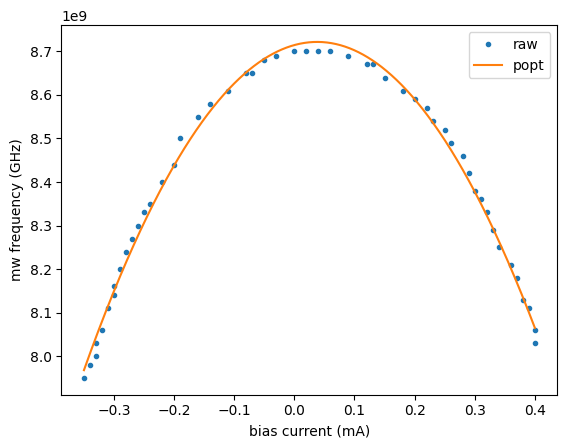

In [57]:
# fitting curve to data points

I_fit = np.linspace(min(I), max(I), 1001)
p0 = (-1.0e15, 1300e-6, 8.86e9)
popt, pcov = opt.curve_fit(f_par, xdata=I, ydata=f, p0=p0)
f_fit = f_par(I_fit, *popt)

plt.plot(I*1e3, f, '.', label="raw")
plt.plot(I_fit*1e3, f_fit, label="popt")
#plt.plot(I_fit*1e3, f_par(I_fit, *p0), label="p0")
plt.ylabel("mw frequency (GHz)")
plt.xlabel("bias current (mA)")
plt.legend()
print(*popt)

xz_landscape deleted


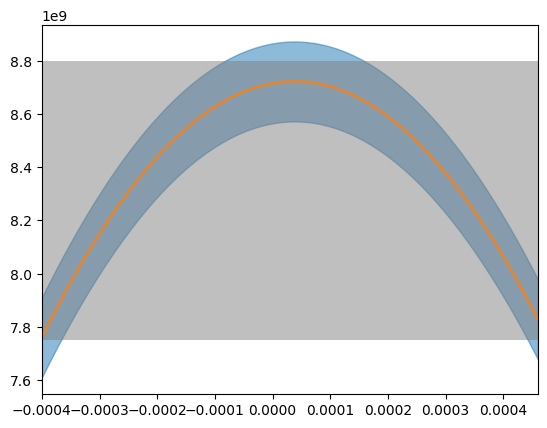

In [58]:
# set curve type for landscape ('parab' or 'hyperb')
# set span around curve to define landscape width

s.landscape.delete_landscape_function_xy()
s.landscape.delete_landscape_function_xz()
s.landscape.generate_fit_function_xy(curve_f='parab',
                                     curve_p=[I, f],
                                     p0=popt,
                                     y_span=300e6
                                    )

#s.landscape.xylandscapes[0]['center_points'] *= 1e9
s.landscape.xylandscapes

s.landscape.plot_xy_landscape()

In [59]:
# Measurement with landscape

mw_src.set_status(True)

s.measure_3D()

mw_src.set_status(False)
IVD.set_current(0)
IVD.set_status(False)

HTML(value="<table style='width:100%'><tr><td> (0/19600) </td><td>&#9992; 2023-05-15 (Mon) 10:25:29    </td><t…

IntProgress(value=0, description='3D VNA sweep GeQCoS4Qv4_3_C28_r3_2tone_7.8_to_8.8_GHz_current_-0.4_to_0.5_mA…

C:\data\EDEL_18\Alex\\sample_C28\\TwoTone_Current\\Res_3\RUMXH2_3D_GeQCoS4Qv4_3_C28_r3_2tone_7.8_to_8.8_GHz_current_-0.4_to_0.5_mA_GeQCoS4Qv4_3_C28_r3\RUMXH2_3D_GeQCoS4Qv4_3_C28_r3_2tone_7.8_to_8.8_GHz_current_-0.4_to_0.5_mA_GeQCoS4Qv4_3_C28_r3.h5


SystemExit: Heat Stop at 0.37993499999999997 mA; Current status: False

C:\qkit\.venv\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Exception in qkit/gui/plot/plot.py while plotting
/entry/data0/centerfreq
x and y must have same first dimension, but have shapes (173,) and (156,)
Plots saved in C:\data\EDEL_18\Alex\sample_C28\TwoTone_Current\Res_3\RUMXH2_3D_GeQCoS4Qv4_3_C28_r3_2tone_7.8_to_8.8_GHz_current_-0.4_to_0.5_mA_GeQCoS4Qv4_3_C28_r3\images


### readout resonator calibration test

In [ ]:
# set the flux bias
dc_bias = 600e-6
set_dc_bias(dc_bias)

In [ ]:
IVD.get_status()

In [37]:
res_freq = vna.get_centerfreq()
vna.get_centerfreq()

In [35]:
# search for optimal working point of resonator (VNA)

mode = "amplitude"
cal_nop = 801
cal_span = 40e6
cal_bw = 1000
cal_avg = 20

# determine resonator frequency (without mw tone)
mw_src.set_status(False) # turn off mw source during search
vna.set_nop(cal_nop)
vna.set_centerfreq(res_freq)
vna.set_span(cal_span) # search the span aroud the resonator position
vna.set_bandwidth(cal_bw) # large IF bandwith, many averages
vna.set_averages(cal_avg)
vna.set_Average(True)

s.measure_1D()

s.freq = vna.get_freqpoints()
s.amp, s.pha = vna.get_tracedata() # dataset with the amp and phase data to tind the resonator

HTML(value="<table style='width:100%'><tr><td> (0/20) </td><td>&#9992; 2023-04-13 (Thu) 14:22:51    </td><td>&…

IntProgress(value=0, description='VNA_tracedata', layout=Layout(width='95%'), max=20)

C:\data\EDEL_18\Alex\RT1ZPN_VNA_tracedata_GeQCoS4Qv4_3_C28_r3\RT1ZPN_VNA_tracedata_GeQCoS4Qv4_3_C28_r3.h5


In [16]:
# Determine f_res with amplitude data

plt.plot(s.freq, -s.amp)

peaks = sig.find_peaks(-s.amp, prominence= 5e-4)
peak = sig.find_peaks(-s.amp, prominence=np.max(peaks[1]['prominences']))
s.centerfreq = s.freq[peak[0][0]]

print("Amplitude: f_res = " + str(round(s.centerfreq/1e9, 3)) + " GHz")

In [ ]:
# Determine f_res with phase data

plt.plot(s.freq, -np.gradient(s.pha))
pha_savgol = -sig.savgol_filter(s.pha, window_length=9, polyorder=3, deriv=1)
plt.plot(s.freq, pha_savgol)

peaks = sig.find_peaks(pha_savgol, prominence= 4e-2)
peak = sig.find_peaks(pha_savgol, prominence=np.max(peaks[1]['prominences']))
s.centerfreq = s.freq[peak[0][0]]

print("Phase: f_res = " + str(round(s.centerfreq/1e9, 3)) + " GHz")